In [ ]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import tensorflow_datasets as tfds

In [ ]:
# GPU 환경 확인
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# **1. Augmentation을 적용한 데이터셋 만들기**

1.1 데이터 불러오기

In [ ]:
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/12000 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/stanford_dogs/0.2.0.incompleteWUKOG0/stanford_dogs-train.tfrecord*...:   0%|  …

Generating test examples...:   0%|          | 0/8580 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/stanford_dogs/0.2.0.incompleteWUKOG0/stanford_dogs-test.tfrecord*...:   0%|   …

Dataset stanford_dogs downloaded and prepared to ~/tensorflow_datasets/stanford_dogs/0.2.0. Subsequent calls will reuse this data.


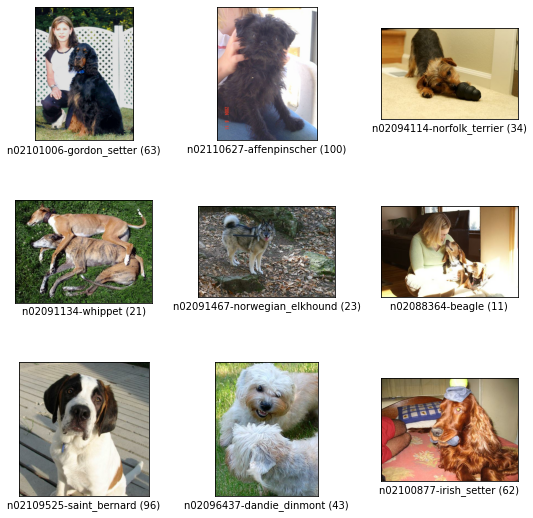

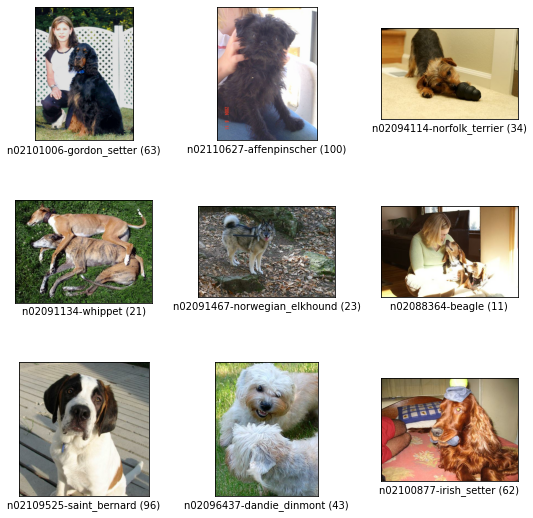

In [ ]:
tfds.show_examples(ds_train, ds_info)

1.2 Augmentation 적용하기


In [ ]:
# 전처리 함수
def normalize_and_resize_img(image, label): # 변환할 이미지와 라벨 
    # Normalizes images: `uint8` -> `float32`
    image = tf.image.resize(image, [224, 224])
    return tf.cast(image, tf.float32) / 255., label

In [ ]:
def augment(image,label):
    image = tf.image.random_flip_left_right(image) # 좌우 반전
    image = tf.image.random_brightness(image, max_delta=0.2) # 밝기 변화
    image = tf.clip_by_value(image, 0, 1)
    return image, label

In [ ]:
# 데이터셋(ds)을 가공하는 메인함수
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16, with_aug=False):
    ds = ds.map(
        normalize_and_resize_img,  # 기본적인 전처리 함수 적용
        num_parallel_calls=2
    )
    if not is_test and with_aug:
        ds = ds.map(
            augment,       # augment 함수 적용
            num_parallel_calls=2 # 병렬처리 수준 지정
        )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)  
    #tf.data.experimental.AUTOTUNE: 어떤 수준의 병렬처리가 tf.data  런타임에 사용되는지 결정
    return ds

In [ ]:
ds_train_no_aug = apply_normalize_on_dataset(ds_train, with_aug=False)

In [ ]:
num_classes = ds_info.features["label"].num_classes

1.3 Augmentation(Cutmix)

- 배치 내의 이미지를 두 개 골라서 한 이미지를 잘라서 다른 한 이미지 위에 올려주는 방식의 augmentation을 CutMix 라고 하고 섞어주는 영역을 바운딩 박스(bounding box)라고 부릅니다.

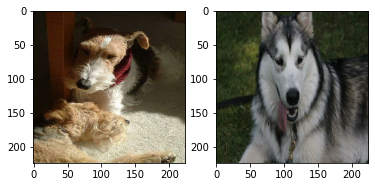

In [ ]:

# 데이터셋에서 이미지 2개를 가져옵니다. 
for i, (image, label) in enumerate(ds_train_no_aug.take(1)):
    if i == 0:
        image_a = image[0]
        image_b = image[1]
        label_a = label[0]
        label_b = label[1]
        break

plt.subplot(1,2,1)
plt.imshow(image_a)

plt.subplot(1,2,2)
plt.imshow(image_b)

plt.show()

In [ ]:
def get_clip_box(image_a, image_b):
    # image.shape = (height, width, channel)
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0]
    
    # get center of box
    x = tf.cast(tf.random.uniform([], 0, image_size_x), tf.int32)
    y = tf.cast(tf.random.uniform([], 0, image_size_y), tf.int32)

    # get width, height of box
    width = tf.cast(image_size_x*tf.math.sqrt(1-tf.random.uniform([], 0, 1)), tf.int32)
    height = tf.cast(image_size_y*tf.math.sqrt(1-tf.random.uniform([], 0, 1)), tf.int32)
    
    # clip box in image and get minmax bbox
    x_min = tf.math.maximum(0, x-width//2)
    y_min = tf.math.maximum(0, y-height//2)
    x_max = tf.math.minimum(image_size_x, x+width//2)
    y_max = tf.math.minimum(image_size_y, y+width//2)
    
    return x_min, y_min, x_max, y_max

In [ ]:
x_min, y_min, x_max, y_max = get_clip_box(image_a, image_b)

print('x : ', x_min, x_max)
print('y : ', y_min, y_max)

x :  tf.Tensor(0, shape=(), dtype=int32) tf.Tensor(167, shape=(), dtype=int32)
y :  tf.Tensor(103, shape=(), dtype=int32) tf.Tensor(224, shape=(), dtype=int32)


In [ ]:
# mix two images
def mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0] 
    middle_left = image_a[y_min:y_max, 0:x_min, :] # image_b의 왼쪽 바깥 영역
    middle_center = image_b[y_min:y_max, x_min:x_max, :]  # image_b의 안쪽 영역
    middle_right = image_a[y_min:y_max, x_max:image_size_x, :] # image_b의 오른쪽 바깥 영역
    middle = tf.concat([middle_left,middle_center,middle_right], axis=1)
    top = image_a[0:y_min, :, :]
    bottom = image_a[y_max:image_size_y, :, :]
    mixed_img = tf.concat([top, middle, bottom],axis=0)
    
    return mixed_img

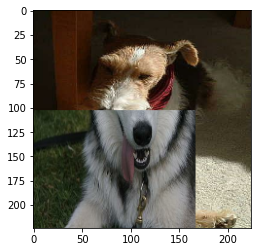

In [ ]:
mixed_img = mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max)
plt.imshow(mixed_img.numpy())
plt.show()

In [ ]:
# mix two labels
def mix_2_labels(label_a, label_b, x_min, y_min, x_max, y_max, num_classes=120):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0] 
    mixed_area = (x_max-x_min)*(y_max-y_min)
    total_area = image_size_x*image_size_y
    ratio = tf.cast(mixed_area/total_area, tf.float32)

    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_label = (1-ratio)*label_a + ratio*label_b
    return mixed_label

In [ ]:
mixed_label = mix_2_labels(label_a, label_b, x_min, y_min, x_max, y_max)
mixed_label

<tf.Tensor: shape=(120,), dtype=float32, numpy=
array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.5972776 , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.     

In [ ]:
def cutmix(image, label, prob=1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0, batch_size),tf.int32)
        image_b = image[j]
        label_b = label[j]
        x_min, y_min, x_max, y_max = get_clip_box(image_a, image_b)
        mixed_imgs.append(mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max))
        mixed_labels.append(mix_2_labels(label_a, label_b, x_min, y_min, x_max, y_max))

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    return mixed_imgs, mixed_labels

1.4 Mixup Augmentation
  - 두 이미지 쌍을 섞을 비율은 일정한 범위 내에서 랜덤하게 뽑는다.
  - 해당 비율 값에 따라 두 이미지의 픽셀별 값과 라벨을 섞어준다. 

In [ ]:
# function for mixup
def mixup_2_images(image_a, image_b, label_a, label_b):
    ratio = tf.random.uniform([], 0, 1)
    
    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_image= (1-ratio)*image_a + ratio*image_b
    mixed_label = (1-ratio)*label_a + ratio*label_b
    
    return mixed_image, mixed_label

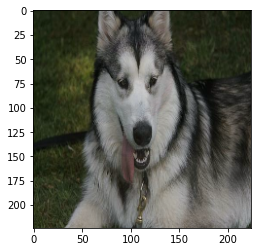

In [ ]:
mixed_img2, mixed_label2 = mixup_2_images(image_a, image_b, label_a, label_b)
plt.imshow(mixed_img2.numpy())
plt.show()

In [ ]:
print(mixed_label2)

tf.Tensor(
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.09892249 0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.9010775  0.         

In [ ]:
def mixup(image, label, prob=1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0,batch_size), tf.int32)
        image_b = image[j]
        label_b = label[j]
        mixed_img, mixed_label = mixup_2_images(image_a, image_b, label_a, label_b)
        mixed_imgs.append(mixed_img)
        mixed_labels.append(mixed_label)

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    return mixed_imgs, mixed_labels

1.5 데이터셋 제작하기

  - CutMix, Mixup augmentation이 적용 가능하도록 apply_normalize_on_dataset 함수 수정

In [ ]:
def normalize_and_resize_img(image, label):
    # Normalizes images: `uint8` -> `float32`
    image = tf.image.resize(image, [224, 224])
    return tf.cast(image, tf.float32) / 255., label

def augment(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.image.random_hue(image, max_delta=0.2)
    image = tf.clip_by_value(image, 0, 1)
    return image, label

def onehot(image, label) :
    label = tf.one_hot(label, num_classes)
    return image, label
    
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16, with_aug=False, with_cutmix=False, with_mixup=False):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=2
    )
    if not is_test and with_aug:
        ds = ds.map(
            augment
        )
    ds = ds.batch(batch_size)
    if not is_test and with_cutmix:
        ds = ds.map(
            cutmix,
            num_parallel_calls=2
        )

    elif not is_test and with_mixup:
        ds = ds.map(
            mixup,
            num_parallel_calls=2
        )
    else:
        ds = ds.map(
            onehot,
            num_parallel_calls=2
        )

    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds


In [ ]:
ds_train_no_aug = apply_normalize_on_dataset(ds_train, with_aug=False)
ds_train_aug = apply_normalize_on_dataset(ds_train, with_aug=True)
ds_train_cutmix = apply_normalize_on_dataset(ds_train, with_cutmix=True)
ds_train_mixup = apply_normalize_on_dataset(ds_train, with_mixup=True)
ds_test = apply_normalize_on_dataset(ds_test, is_test=True)



# **2. 모델 만들기**

2.1 ResNet50 with no augmentation

In [ ]:
resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])



94781440/94765736 [==============================] - 1s 0us/step


2.2 ResNet50 with augmentation

In [ ]:
aug_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

2.3 ResNet50 with CutMix augmentation

In [ ]:
cutmix_aug_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

2.4 ResNet50 with Muixup augmentation

In [ ]:
mixup_aug_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])



# **3. 모델 훈련하기**


In [ ]:
EPOCH = 30

In [ ]:
resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
    metrics=['accuracy'],
)


aug_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
    metrics=['accuracy'],
)

cutmix_aug_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
    metrics=['accuracy'],
)

mixup_aug_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
    metrics=['accuracy'],
)

In [ ]:
history_resnet50_no_aug = resnet50.fit(
    ds_train_no_aug, # augmentation 적용하지 않은 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/30
750/750 [==============================] - 168s 203ms/step - loss: 2.1980 - accuracy: 0.4488 - val_loss: 3.4014 - val_accuracy: 0.2063
Epoch 2/30
750/750 [==============================] - 154s 205ms/step - loss: 0.6901 - accuracy: 0.8130 - val_loss: 1.0902 - val_accuracy: 0.6774
Epoch 3/30
750/750 [==============================] - 154s 205ms/step - loss: 0.2036 - accuracy: 0.9602 - val_loss: 0.9225 - val_accuracy: 0.7280
Epoch 4/30
750/750 [==============================] - 154s 205ms/step - loss: 0.0518 - accuracy: 0.9960 - val_loss: 0.8866 - val_accuracy: 0.7439
Epoch 5/30
750/750 [==============================] - 155s 207ms/step - loss: 0.0208 - accuracy: 0.9998 - val_loss: 0.8969 - val_accuracy: 0.7417
Epoch 6/30
750/750 [==============================] - 154s 205ms/step - loss: 0.0125 - accuracy: 1.0000 - val_loss: 0.9041 - val_accuracy: 0.7424
Epoch 7/30
750/750 [==============================] - 154s 206ms/step - loss: 0.0094 - accuracy: 1.0000 - val_loss: 0.9146 -

In [ ]:
history_resnet50_aug = aug_resnet50.fit(
    ds_train_aug, 
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/30
750/750 [==============================] - 162s 206ms/step - loss: 2.3564 - accuracy: 0.4147 - val_loss: 2.9711 - val_accuracy: 0.2733
Epoch 2/30
750/750 [==============================] - 154s 205ms/step - loss: 1.0302 - accuracy: 0.7025 - val_loss: 1.2692 - val_accuracy: 0.6370
Epoch 3/30
750/750 [==============================] - 154s 205ms/step - loss: 0.5883 - accuracy: 0.8302 - val_loss: 1.1656 - val_accuracy: 0.6662
Epoch 4/30
750/750 [==============================] - 154s 205ms/step - loss: 0.3296 - accuracy: 0.9190 - val_loss: 1.0896 - val_accuracy: 0.6930
Epoch 5/30
750/750 [==============================] - 154s 206ms/step - loss: 0.1816 - accuracy: 0.9620 - val_loss: 0.9948 - val_accuracy: 0.7196
Epoch 6/30
750/750 [==============================] - 154s 206ms/step - loss: 0.0962 - accuracy: 0.9852 - val_loss: 1.0249 - val_accuracy: 0.7129
Epoch 7/30
750/750 [==============================] - 154s 206ms/step - loss: 0.0676 - accuracy: 0.9894 - val_loss: 0.9667 -

In [ ]:
history_resnet50_cutmix = cutmix_aug_resnet50.fit(
    ds_train_cutmix, 
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/30
750/750 [==============================] - 163s 209ms/step - loss: 3.8104 - accuracy: 0.2167 - val_loss: 3.6616 - val_accuracy: 0.1679
Epoch 2/30
750/750 [==============================] - 155s 207ms/step - loss: 2.9354 - accuracy: 0.4376 - val_loss: 1.4090 - val_accuracy: 0.6033
Epoch 3/30
750/750 [==============================] - 156s 208ms/step - loss: 2.6410 - accuracy: 0.5343 - val_loss: 1.2511 - val_accuracy: 0.6470
Epoch 4/30
750/750 [==============================] - 155s 207ms/step - loss: 2.4340 - accuracy: 0.6008 - val_loss: 1.2569 - val_accuracy: 0.6538
Epoch 5/30
750/750 [==============================] - 155s 207ms/step - loss: 2.2619 - accuracy: 0.6535 - val_loss: 1.3708 - val_accuracy: 0.6339
Epoch 6/30
750/750 [==============================] - 156s 207ms/step - loss: 2.1454 - accuracy: 0.6850 - val_loss: 1.4952 - val_accuracy: 0.6065
Epoch 7/30
750/750 [==============================] - 155s 207ms/step - loss: 2.0480 - accuracy: 0.7196 - val_loss: 1.2322 -

In [ ]:
history_resnet50_mixup = mixup_aug_resnet50.fit(
    ds_train_mixup,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/30
750/750 [==============================] - 163s 209ms/step - loss: 3.7319 - accuracy: 0.2394 - val_loss: 3.5681 - val_accuracy: 0.1874
Epoch 2/30
750/750 [==============================] - 156s 208ms/step - loss: 2.8435 - accuracy: 0.4848 - val_loss: 1.5363 - val_accuracy: 0.5852
Epoch 3/30
750/750 [==============================] - 156s 208ms/step - loss: 2.5684 - accuracy: 0.5867 - val_loss: 1.5096 - val_accuracy: 0.5771
Epoch 4/30
750/750 [==============================] - 156s 208ms/step - loss: 2.3843 - accuracy: 0.6581 - val_loss: 1.4213 - val_accuracy: 0.6142
Epoch 5/30
750/750 [==============================] - 156s 208ms/step - loss: 2.2568 - accuracy: 0.7117 - val_loss: 1.5232 - val_accuracy: 0.5927
Epoch 6/30
750/750 [==============================] - 156s 208ms/step - loss: 2.1587 - accuracy: 0.7416 - val_loss: 1.1998 - val_accuracy: 0.6684
Epoch 7/30
750/750 [==============================] - 156s 208ms/step - loss: 2.0651 - accuracy: 0.7700 - val_loss: 1.2795 -



# **4. 훈련 과정 시각화하기**
  훈련 과정의 히스토리를 그래프로 시각화

4-1. Accuracy (val)

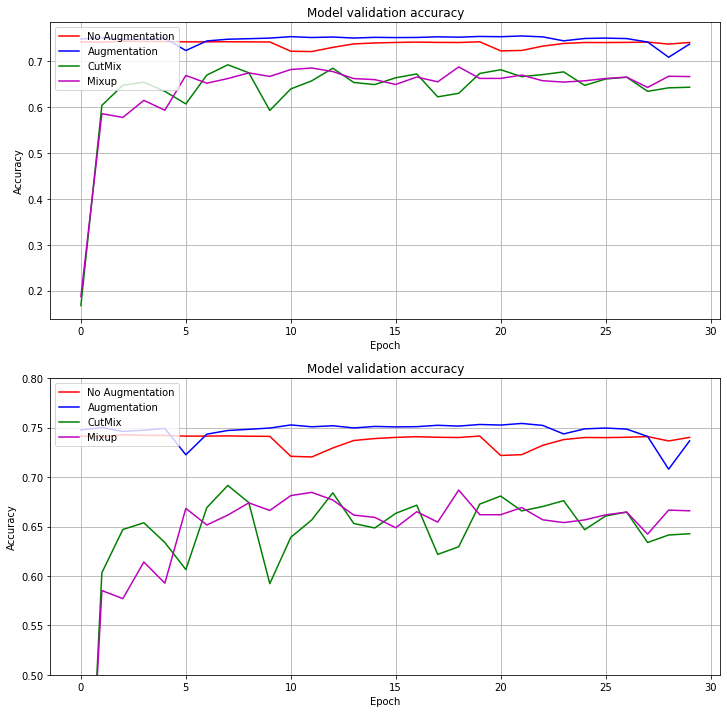

In [ ]:
# 훈련 과정 시각화
plt.figure(figsize=(12, 12))

plt.subplot(2, 1, 1)
plt.plot(history_resnet50_no_aug.history['val_accuracy'], 'r')
plt.plot(history_resnet50_aug.history['val_accuracy'], 'b')
plt.plot(history_resnet50_cutmix.history['val_accuracy'], 'g')
plt.plot(history_resnet50_mixup.history['val_accuracy'], 'm')

plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'Augmentation', 'CutMix', 'Mixup'], loc='upper left')
plt.grid(True)

plt.subplot(2, 1, 2)
plt.plot(history_resnet50_no_aug.history['val_accuracy'], 'r')
plt.plot(history_resnet50_aug.history['val_accuracy'], 'b')
plt.plot(history_resnet50_cutmix.history['val_accuracy'], 'g')
plt.plot(history_resnet50_mixup.history['val_accuracy'], 'm')

plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'Augmentation', 'CutMix', 'Mixup'], loc='upper left')
plt.grid(True)
plt.ylim(0.50, 0.80)   

plt.show()

4,2 Loss (val)

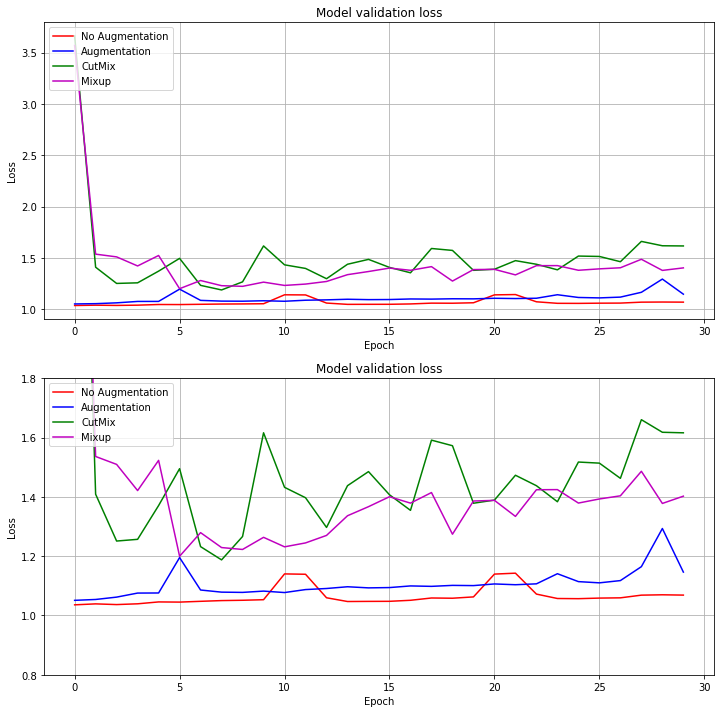

In [ ]:
# 훈련 과정 시각화
plt.figure(figsize=(12, 12))

plt.subplot(2, 1, 1)
plt.plot(history_resnet50_no_aug.history['val_loss'], 'r')
plt.plot(history_resnet50_aug.history['val_loss'], 'b')
plt.plot(history_resnet50_cutmix.history['val_loss'], 'g')
plt.plot(history_resnet50_mixup.history['val_loss'], 'm')

plt.title('Model validation loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'Augmentation', 'CutMix', 'Mixup'], loc='upper left')
plt.grid(True)

plt.subplot(2, 1, 2)
plt.plot(history_resnet50_no_aug.history['val_loss'], 'r')
plt.plot(history_resnet50_aug.history['val_loss'], 'b')
plt.plot(history_resnet50_cutmix.history['val_loss'], 'g')
plt.plot(history_resnet50_mixup.history['val_loss'], 'm')

plt.title('Model validation loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'Augmentation', 'CutMix', 'Mixup'], loc='upper left')
plt.grid(True)
plt.ylim(0.80, 1.80)  
plt.show()

plt.show()

# **5. Augmentation에 의한 모델 성능 비교**

Accuracy 값과 Loss 값을 종합적으로 비교해보면 augmentation -> no augmentation -> mixup -> cutmix 순으로 결과가 좋았다. cutmix가 기존의 autmentation에서 cutout과 mixup를 보완해서 성능을 개선하기 위해 만들어 진 것인데 cutmix가 상대적으로 결과가 안좋게 나온것은 의외였다. 실습에서의 코드가 cutmix, mixup 기법을 적용한 데이터만 사용하고 기본 augmentation 기법을 사용한 데이터를 더하지 않은 그대로의 코드를 그대로 썼기 때문에 이런 결과가 나온것 같다. 시간이 된다면 다음에는 no augmentation + 기본 augmentation + cutmix (또는 mixup)을 각각 적용한 데이터셋들의 합으로 모델을 훈련하고, 논문에서는 300 epochs 만큼 훈련했는데 좋은 결과가 나왔기 때문에 epoch 횟수를 더 늘리면 더 좋은 결과가 나올 것 같다.    


루브릭

아래의 기준을 바탕으로 프로젝트를 평가합니다.

평가문항	상세기준
1. CutMix와 MixUp 기법을 ResNet50 분류기에 성공적으로 적용하였는가?

CutMix와 MixUp을 적용한 데이터셋으로 훈련한 각각의 ResNet 모델이 수렴하였다.
2. 다양한 실험을 통해 태스크에 최적인 Augmentation 기법을 찾아내었는가?

각 Augmentation 기법을 적용하고, 그에 따른 성능 비교 분석 및 문제점을 서술하였음
3. 여러가지 Augmentation 기법을 적용한 결과를 체계적으로 비교분석하였는가?

기본 Augmentation, CutMix, MixUp이 적용된 결과를 시각화와 함께 체계적으로 분석하였다.